In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! pip install torch_geometric
! pip install rdkit
! pip install pytorch_lightning
# ! pip install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 17.6 MB/s eta 0:00:00


In [ ]:
import os
from sklearn.model_selection import train_test_split
import torch
import torch_geometric

dataset = torch_geometric.datasets.QM9(root='./data/', transform=None)

train_data, test_valid_data  = train_test_split(dataset, test_size=0.2, random_state=42)
test_data, valid_data = train_test_split(test_valid_data , test_size=0.5, random_state=42)

# Define the paths to save the splits
save_path = './data/q9_splits'
os.makedirs(save_path, exist_ok=True)

train_path = os.path.join(save_path, 'train.pt')
test_path = os.path.join(save_path, 'test.pt')
valid_path = os.path.join(save_path, 'valid.pt')

# Save the splits
torch.save(train_data, train_path)
torch.save(test_data, test_path)
torch.save(valid_data, valid_path)

Extracting data/raw/qm9.zip


KeyboardInterrupt: 

In [1]:
import numpy as np
import torch
import torch_geometric

dataset = torch_geometric.datasets.QM9(root='./data/', transform=None)
num_features = dataset.num_features
num_classes = dataset.num_classes
path = '/content/drive/MyDrive/q9_splits'
train_data = torch.load(f'{path}/train.pt')
test_data = torch.load(f'{path}/test.pt')
valid_data = torch.load(f'{path}/valid.pt')


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import pytorch_lightning as pl
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, TransformerConv, GATConv,GATv2Conv, NNConv, CGConv, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
BATCH_SIZE = 4
from torchmetrics import MeanAbsoluteError

class RGNN(pl.LightningModule):
    def __init__(self, num_features, embedding_size, num_layers, mlp=False, hidden_size_mlp=4):
        super(RGNN, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        hidden_channels = 128
        for i in range(num_layers):
            self.convs.append(TransformerConv(
                num_features if i == 0 else hidden_channels,
                hidden_channels if i < num_layers - 1 else embedding_size,
                edge_dim=4))

        # Output layer
        if mlp:
          self.out = nn.Sequential(
              nn.Linear(embedding_size, hidden_size_mlp),
              nn.ReLU(),
              nn.Linear(hidden_size_mlp, 1)
          )
        else:
            self.out = nn.Sequential(
                nn.Linear(embedding_size, 1))
        #
        self.train_mae = MeanAbsoluteError()
        self.valid_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()

    def forward(self, data):
        x = data.x.float()
        edge_index = data.edge_index
        edge_attr = data.edge_attr

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_attr)
            if i != self.num_layers - 1:
                x = x.relu()

        hidden = gmp(x, data.batch)
        out = self.out(hidden)
        return out, hidden

    def training_step(self, data, batch_idx):
        logits, _ = self(data)
        y = data.y[:,0].squeeze()
        logits = logits.squeeze()
        loss = nn.functional.mse_loss(logits, y)
        self.log("train_loss", loss, batch_size=BATCH_SIZE, prog_bar=True,on_epoch=True, on_step=False , logger=True)
        self.train_mae.update(logits, y)
        return loss


    def on_train_epoch_end(self):
        self.log("train_mae", self.train_mae.compute(), batch_size=BATCH_SIZE, prog_bar=True)
        self.train_mae.reset()

    def validation_step(self, data, batch_idx):
        logits, h = self(data)
        y = data.y[:,0].squeeze()
        logits = logits.squeeze()
        loss = nn.functional.mse_loss(logits, y)
        self.log("valid_loss", loss, batch_size=BATCH_SIZE, prog_bar=True, on_epoch=True, logger=True)
        self.valid_mae.update(logits, y)
        return loss

    def on_validation_epoch_end(self):
        self.log("valid_mae", self.valid_mae.compute(), batch_size=BATCH_SIZE, prog_bar=True)
        self.valid_mae.reset()

    def test_step(self, data, batch_idx):
        logits, h = self(data)
        y = data.y[:,0].squeeze()
        logits = logits.squeeze()
        loss = nn.functional.mse_loss(logits, y)
        self.log("test_loss", loss, batch_size=BATCH_SIZE, prog_bar=True)
        self.test_mae.update(logits, y)
        self.log("test_mae", self.test_mae.compute(), batch_size=BATCH_SIZE, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [8]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

csv_logger = CSVLogger(
    save_dir='./',
    name='csv_file'
)
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning module
hidden_size = 32
embedding_size = [1, 2, 64]
model = RGNN(num_features, embedding_size=embedding_size[0], num_layers=5,  mlp=True, hidden_size_mlp=hidden_size)
print(model)
trainer = pl.Trainer(max_epochs=100, callbacks=[EarlyStopping(monitor='valid_loss')], logger=[csv_logger, logger])  # experiment with max epochs
trainer.fit(model, train_loader, val_dataloaders=valid_loader)
trainer.test(model, test_loader)
torch.save(model.state_dict(), 'model_regeresion.pth')


RGNN(
  (convs): ModuleList(
    (0): TransformerConv(11, 128, heads=1)
    (1-3): 3 x TransformerConv(128, 128, heads=1)
    (4): TransformerConv(128, 1, heads=1)
  )
  (out): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (train_mae): MeanAbsoluteError()
  (valid_mae): MeanAbsoluteError()
  (test_mae): MeanAbsoluteError()
)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


<ipython-input-9-8e09f4c17a56>:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter1 = sns.scatterplot(x=embeddings.flatten(), y=reals.flatten(), palette='viridis', label="real", alpha=0.5)
<ipython-input-9-8e09f4c17a56>:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(x=embeddings.flatten(), y=outputs.flatten(), palette='viridis', label="predicted")
<ipython-input-9-8e09f4c17a56>:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  line = sns.lineplot(x=embeddings.flatten(), y=outputs.flatten(), palette='viridis')


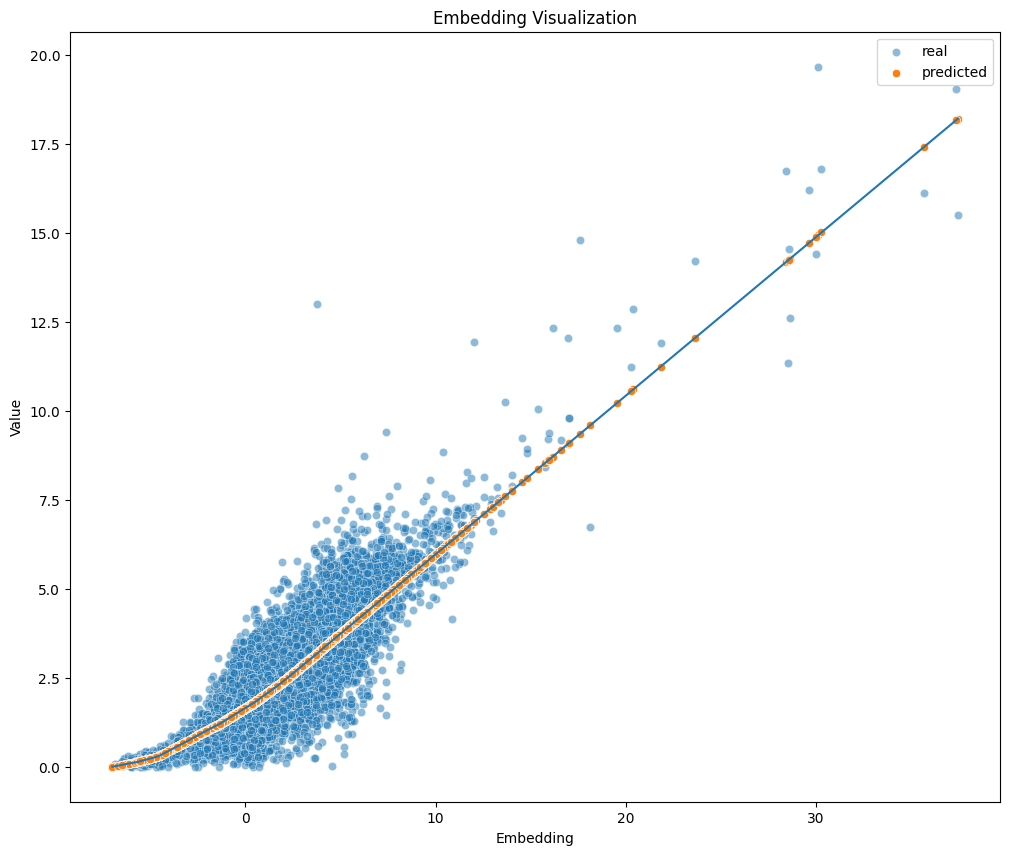

In [9]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

def visualize1(model):

    model.eval()
    test_loader = DataLoader(test_data, batch_size=64)
    reals,embeddings, outputs = [], [], []

    for batch in test_loader:
        # batch = batch.to(device)
        output, h = model(batch)
        outputs.extend(output.cpu().detach().numpy())
        reals.extend(batch.y[:,0].cpu().numpy())
        embeddings.extend(h.cpu().detach().numpy())

    plt.figure(figsize=(12, 10))
    embeddings = np.array(embeddings)
    outputs = np.array(outputs)
    reals = np.array(reals)

    scatter1 = sns.scatterplot(x=embeddings.flatten(), y=reals.flatten(), palette='viridis', label="real", alpha=0.5)
    scatter = sns.scatterplot(x=embeddings.flatten(), y=outputs.flatten(), palette='viridis', label="predicted")
    line = sns.lineplot(x=embeddings.flatten(), y=outputs.flatten(), palette='viridis')
    plt.title('Embedding Visualization')
    plt.xlabel('Embedding')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

model.load_state_dict(torch.load(r'/content/model_regeresion_1_mlp.pth'))
visualize1(model)


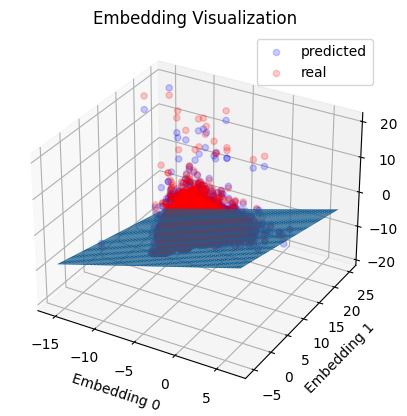

In [7]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from scipy.interpolate import griddata

def visualize2(model, lin):

    model.eval()
    test_loader = DataLoader(test_data, batch_size=64)
    reals,embeddings, outputs = [], [], []

    for batch in test_loader:
        # batch = batch.to(device)
        output, h = model(batch)
        outputs.extend(output.cpu().detach().numpy())
        reals.extend(batch.y[:,0].cpu().numpy())
        embeddings.extend(h.cpu().detach().numpy())
    embeddings = np.array(embeddings)
    outputs = np.array(outputs)
    reals = np.array(reals)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings[:,0].flatten(), embeddings[:,1].flatten(), outputs.flatten(), c='b', marker='o', label="predicted", alpha=0.2)
    ax.scatter(embeddings[:,0].flatten(), embeddings[:,1].flatten(), reals.flatten(), c='r', marker='o', label="real", alpha=0.2)

    h = .01
    x_min, x_max = embeddings[:, 0].min() , embeddings[:, 0].max()
    y_min, y_max = embeddings[:, 1].min() , embeddings[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
    meshgrid_points_tensor = torch.FloatTensor(meshgrid_points)

    if lin:
        linear_layer = torch.nn.Linear(2, 1)
        with torch.no_grad():
          predictions = linear_layer(meshgrid_points_tensor)
    else:
      linear_layer = torch.nn.Linear(2, 32)
      nl_layer = nn.ReLU()
      lin2_layer = nn.Linear(32, 1)
      with torch.no_grad():
        predictions = linear_layer(meshgrid_points_tensor)
        predictions = nl_layer(predictions)
        predictions = lin2_layer(predictions)
    predictions = predictions.reshape(xx.shape)
    predictions = np.nan_to_num(predictions)

    ax.plot_surface(xx, yy, predictions)

    # ax.plot_trisurf(embeddings[:,0].flatten(), embeddings[:,1].flatten(), outputs.flatten(), cmap='viridis', alpha=0.5)
    ax.set_xlabel('Embedding 0')
    ax.set_ylabel('Embedding 1')
    ax.set_zlabel('Value')
    ax.set_title('Embedding Visualization')
    plt.legend()
    plt.show()

model.load_state_dict(torch.load(r'/content/model_regeresion_2_lin.pth'))
visualize2(model, True)
